In [140]:
%matplotlib inline
import numpy as np
import pandas as pd  
from sklearn import cross_validation
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics
from ggplot import *
import random       

In [141]:
def build_group(x_arr, y_arr, col_names):
    group = pd.concat([pd.DataFrame(x_arr), pd.DataFrame(y_arr)], axis=1)
    group.columns = col_names
    #group["post_purchase"] = y_arr #purchase_target
    return group

In [142]:
def eval_group(group_df, orig_df):
    
    combo_df = pd.merge(group_df, orig_df, how='inner', on="uid", suffixes=('_group', '_orig'), copy=True)
    
    print "How many PREDICTED purchasers were in the High Group?"
    print len(combo_df)
    print 
    print "How many ACTUAL purchasers were in the high group?"
    print sum(combo_df.post_purchase > 0)
    print
    print "How many ACTUAL purchasers in high group DID WE REACH?"
    print sum((combo_df.impressions > 0) & (combo_df.post_purchase > 0))
    print 
    print "How many ACTUAL purchasers in high group had AT LEAST 5 IMPRESSIONS?"
    print sum((combo_df.impressions > 4) & (combo_df.post_purchase > 0))
    print 
    print "How many ACTUAL purchasers in high group had and ENGAGEMENT?"
    print sum((combo_df.engagements > 0) & (combo_df.post_purchase > 0))
    print 
    non_impression_purchasers = combo_df[(combo_df.impressions == 0) & (combo_df.post_purchase > 0)]
    print "How many many PREDICTED purchasers did NOT GET IMPRESSION and ACTUALLY PURCHASED?"
    print len(non_impression_purchasers)
    print  
    print "Potential INCREASE in purchases by reaching un-reached group"
    print  sum(non_impression_purchasers.post_purchase)
    print
    non_engaged_purchasers = combo_df[(combo_df.engagements == 0) & (combo_df.post_purchase > 0)]
    print "How many many PREDICTED purchasers did NOT GET ENGAGEMENT and ACTUALLY PURCHASED?"
    print len(non_engaged_purchasers)
    print
    print "Potential INCREASE of purchases from by engaging non engaged purchasers"
    print  sum(non_engaged_purchasers.post_purchase)
    

In [143]:
#import data 
df = pd.read_table('../data/upp_v9_Sephora_Jan2015-Feb2015.txt', header=0); 
len(df.columns)

14

In [144]:
df.head()

,mid,uid,impressions,last_impression,engagements,last_engagement,clicks,last_click,cart_views,last_cart_view,purchases,price,last_purchase,post_purchase_price
0,400,00000BD1AA0E11E481925F0699696EE1,0,0,0,0,0,0,0,0,0,0,0,0
1,400,0000702D94BD11E486C86F14776A5CF4,0,0,0,0,0,0,0,0,0,0,0,0
2,400,00007338AF4C11E48A01434ACCF5FAC7,9,1423376179,1,1423376201,0,0,0,0,0,0,0,0
3,400,0000B0889B6D11E489186336DF5B619E,0,0,0,0,0,0,0,0,0,0,0,0
4,400,0000DDADACF311E481C4619681057637,23,1423786497,1,1423786468,0,0,0,0,0,0,0,0


In [145]:
#filter down to desired merchants
mid = 400 #used in next month as well
mid_filter = df["mid"] == mid
df = df[mid_filter]
df_orig = df.copy()

In [146]:
#for classification, convert post_purchase_price to 1 or 0
df['post_purchase'] = (df['post_purchase_price'] > 0)*1
df.drop(['post_purchase_price'], axis=1, inplace=True)

In [147]:
#correlation of features
df.corr()

,mid,impressions,last_impression,engagements,last_engagement,clicks,last_click,cart_views,last_cart_view,purchases,price,last_purchase,post_purchase
mid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
impressions,NaN,1.000000,0.340145,0.770316,0.429562,0.124751,0.134737,0.171790,0.203306,0.224258,0.129912,0.240836,0.136907
last_impression,NaN,0.340145,1.000000,0.271023,0.518466,0.068188,0.082079,0.088118,0.145767,0.121863,0.070912,0.143555,0.082221
engagements,NaN,0.770316,0.271023,1.000000,0.521187,0.138105,0.142491,0.145218,0.171109,0.184069,0.104176,0.197050,0.105938
last_engagement,NaN,0.429562,0.518466,0.521187,1.000000,0.128130,0.154048,0.130409,0.201930,0.158527,0.092218,0.181134,0.093121
clicks,NaN,0.124751,0.068188,0.138105,0.128130,1.000000,0.831709,0.039181,0.035347,0.039417,0.022646,0.037206,0.022444
last_click,NaN,0.134737,0.082079,0.142491,0.154048,0.831709,1.000000,0.041765,0.041105,0.043627,0.025250,0.042619,0.025222
cart_views,NaN,0.171790,0.088118,0.145218,0.130409,0.039181,0.041765,1.000000,0.449958,0.529505,0.366643,0.383584,0.155806
last_cart_view,NaN,0.203306,0.145767,0.171109,0.201930,0.035347,0.041105,0.449958,1.000000,0.480403,0.314295,0.607161,0.147028
purchases,NaN,0.224258,0.121863,0.184069,0.158527,0.039417,0.043627,0.529505,0.480403,1.000000,0.649518,0.786934,0.212432


In [148]:
#drop unwanted variables
df.drop(['impressions', 'engagements', 'clicks'], axis=1, inplace=True)
df.drop(['last_impression', 'last_engagement', 'last_click', 'last_purchase', 'last_cart_view', 'last_cart_view'], axis=1, inplace=True)

In [149]:
#correlation of features
df.corr()

,mid,cart_views,purchases,price,post_purchase
mid,NaN,NaN,NaN,NaN,NaN
cart_views,NaN,1.000000,0.529505,0.366643,0.155806
purchases,NaN,0.529505,1.000000,0.649518,0.212432
price,NaN,0.366643,0.649518,1.000000,0.136021
post_purchase,NaN,0.155806,0.212432,0.136021,1.000000


In [150]:
#scaling vars if needed
#df.cart_views = preprocessing.scale(df.cart_views*1.0)

In [151]:
#split data into train and test sets
x_train, x_test, y_train, y_test = cross_validation.train_test_split(df.iloc[:,:len(df.columns)-1], df.iloc[:,len(df.columns)-1], test_size=0.4) 

In [152]:
#remove mid and uid;  keep original for referencing specific uids
X_train = np.delete(x_train, [0,1], 1)
X_test  = np.delete(x_test, [0,1], 1)

In [153]:
#size and percentage or post purchasers in the data set
print len(y_train)
print sum(y_train)/(len(y_train)*1.0)

7877774
0.0106371419134


In [154]:
#train model
logistic = LogisticRegression()
model = logistic.fit(X_train, y_train) 

In [155]:
#make predictions on training data
X_train = X_train.astype(float) #needed to prevent error
model_predictions = model.predict_proba(X_train); 
model_predictions = model_predictions[:, 1]

In [156]:
#model score - R^2
print model.score(X_train, y_train)  

0.989313859474


In [18]:
#setting up df for double density plot
df_plot = pd.DataFrame()
predictions = pd.DataFrame(model_predictions, columns=["predictions"])
actual = pd.DataFrame(y_train > 0, columns=["actual"])

df_plot["actual"] = actual * 1
df_plot["predictions"] = predictions
df_plot.head()

,actual,predictions
0,0,0.008279
1,0,0.008279
2,0,0.008279
3,0,0.008279
4,0,0.008279


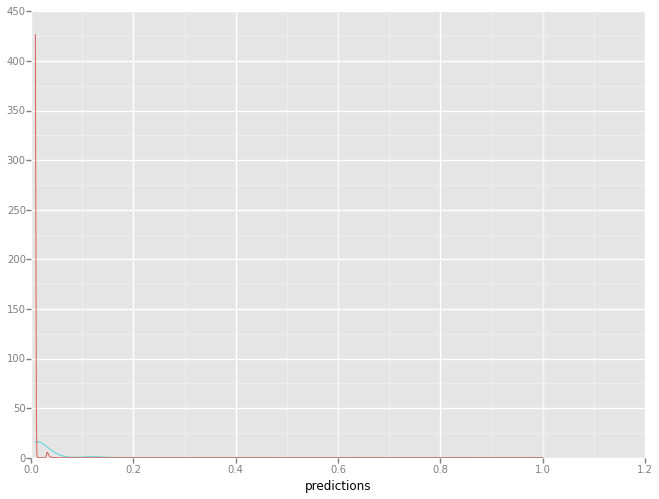

<ggplot: (8750145802081)>

In [19]:
#double density plot
ggplot(df_plot, aes(x='predictions', color='actual')) + geom_density()

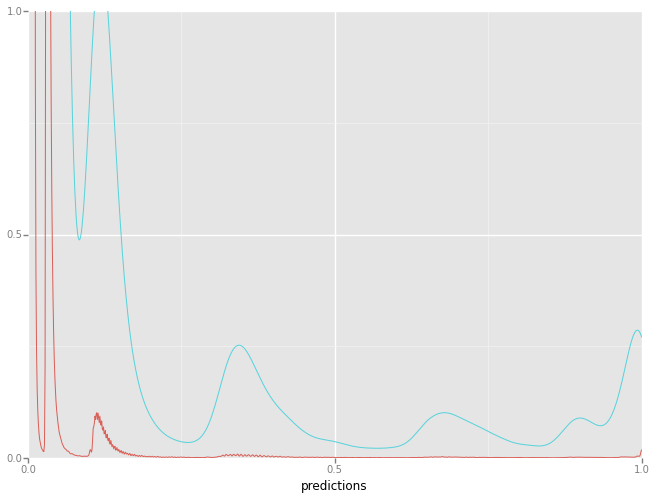

<ggplot: (8750094377017)>

In [20]:
#double density zoom
ggplot(df_plot, aes(x='predictions', color='actual')) + geom_density() + xlim(0,1) + ylim(0, 1)

In [181]:
#manually set threshold based on dd plot
threshold = .5

In [182]:
#set values to true false for various metrics
y_actual  = y_train > 0
y_predict = model_predictions >= threshold

In [183]:
#confusion matrix
cm = pd.crosstab(y_actual, y_predict, rownames=["Actual"], colnames=["Pred"]) 
cm

Pred,False,True
Actual,,
False,7785502,8475
True,78154,5643


In [184]:
#overall accuracy
metrics.accuracy_score(y_actual, y_predict)

0.98900336567157165

In [185]:
#precision
metrics.precision_score(y_actual, y_predict)

0.39970250743731411

In [ ]:
#recall
metrics.recall_score(y_actual, y_predict)

0.067341312934830602

In [ ]:
#summary output
group = build_group(x_train[y_predict], y_train[y_predict], df.columns)
eval_group(group, df_orig)

In [ ]:
#look at users in data above certain threshold
df_prediction_train = pd.concat([pd.DataFrame(x_train), pd.DataFrame(y_train), pd.DataFrame(model_predictions)], axis=1)
df_prediction_train.columns = np.append(df.columns, ['prediction'])
df_prediction_train[y_predict]

In [28]:
#validation test set

In [29]:
#random set of rows from testing data
sample_index = random.sample(range(len(y_test)-1), (len(y_test)-1)/10) #use standard lib, unique random numbers
x_val = x_test[sample_index]
X_val = X_test[sample_index]        
y_val = y_test[sample_index]   

In [30]:
#sample predictions
X_val = X_val.astype(float)
val_predictions = model.predict_proba(X_val); 
val_predictions = val_predictions[:, 1]

In [31]:
#set values to true false for various metrics
y_actual  = y_val > 0
y_predict = val_predictions >= threshold

In [32]:
#confusion matrix
cm = pd.crosstab(y_actual, y_predict, rownames=["Actual"], colnames=["Pred"]) 
cm

Pred,False,True
Actual,,
False,519414,217
True,5353,200


In [33]:
#overall accuracy - validation 
metrics.accuracy_score(y_actual, y_predict)

0.98939419327321476

In [34]:
#precision
metrics.precision_score(y_actual, y_predict) 

0.47961630695443647

In [35]:
#recall
metrics.recall_score(y_actual, y_predict)

0.036016567621105708

In [36]:
#summary output
group = build_group(x_val[y_predict], y_val[y_predict], df.columns)
eval_group(group, df_orig)

How many PREDICTED purchasers were in the High Group?
417

How many ACTUAL purchasers were in the high group?
200

How many ACTUAL purchasers in high group DID WE REACH?
171

How many ACTUAL purchasers in high group had AT LEAST 5 IMPRESSIONS?
155

How many ACTUAL purchasers in high group had and ENGAGEMENT?
130

How many many PREDICTED purchasers did NOT GET IMPRESSION and ACTUALLY PURCHASED?
29

Potential INCREASE in purchases by reaching un-reached group
8462.2

How many many PREDICTED purchasers did NOT GET ENGAGEMENT and ACTUALLY PURCHASED?
70

Potential INCREASE of purchases from by engaging non engaged purchasers
70


In [37]:
#prep data set for next data range

In [105]:
#import data
df_next = pd.read_table('../data/upp_v9_Sephora_Feb2015-Mar2015.txt', header=0); 
len(df_next.columns)

14

In [106]:
#filter down to desired merchants
mid_filter = df_next["mid"] == mid
df_next = df_next[mid_filter]
df_next_orig = df_next.copy()

In [107]:
#for classification, convert post_purchase_price to 1 or 0
df_next['post_purchase'] = (df_next['post_purchase_price'] > 0)*1
df_next.drop(['post_purchase_price'], axis=1, inplace=True)

In [108]:
#drop unwanted variables
df_next.drop(['impressions', 'engagements', 'clicks'], axis=1, inplace=True)
df_next.drop(['last_impression', 'last_engagement', 'last_click', 'last_purchase', 'last_cart_view', 'last_cart_view'], axis=1, inplace=True)

In [109]:
#get sample from next month
sample_index = random.sample(range(len(df_next)-1), (len(df_next)-1)/10) #use standard lib, unique random numbers
x_next = df_next.iloc[sample_index,:len(df_next.columns)-1].as_matrix()
X_next = df_next.iloc[sample_index, 2:len(df_next.columns)-1].as_matrix()
y_next = df_next.iloc[sample_index, len(df_next.columns)-1].as_matrix()

In [110]:
#make predictions on training data
X_next = X_next.astype(float) #needed to prevent error
model_predictions_next = model.predict_proba(X_next); 
model_predictions_next = model_predictions_next[:, 1]

In [111]:
#model score - R^2
print model.score(X_next, y_next) 

0.985306732169


In [112]:
#set values to true false for various metrics
y_actual  = y_next > 0
y_predict = model_predictions_next >= threshold

In [113]:
#confusion matrix
cm = pd.crosstab(y_actual, y_predict, rownames=["Actual"], colnames=["Pred"]) 
cm

Pred,False,True
Actual,,
False,1278932,555
True,18527,676


In [114]:
#overall accuracy - validation 
metrics.accuracy_score(y_actual, y_predict)

0.9853067321685699

In [115]:
#precision
metrics.precision_score(y_actual, y_predict) 

0.54914703493095041

In [116]:
#recall
metrics.recall_score(y_actual, y_predict)

0.035202832890694161

In [119]:
#summary output
group = build_group(x_next[y_predict], y_next[y_predict], df_next.columns)
eval_group(group, df_next_orig)

How many PREDICTED purchasers were in the High Group?
1231

How many ACTUAL purchasers were in the high group?
676

How many ACTUAL purchasers in high group DID WE REACH?
568

How many ACTUAL purchasers in high group had AT LEAST 5 IMPRESSIONS?
529

How many ACTUAL purchasers in high group had and ENGAGEMENT?
428

How many many PREDICTED purchasers did NOT GET IMPRESSION and ACTUALLY PURCHASED?
108

Potential INCREASE in purchases by reaching un-reached group
108

How many many PREDICTED purchasers did NOT GET ENGAGEMENT and ACTUALLY PURCHASED?
248

Potential INCREASE of purchases from by engaging non engaged purchasers
248


In [139]:
#look at users in data above certain threshold
df_prediction_next = pd.concat([pd.DataFrame(x_next), pd.DataFrame(y_next), pd.DataFrame(model_predictions_next)], axis=1)
df_prediction_next.columns = np.append(df_next.columns, ['prediction'])
df_prediction_next[y_predict]

,mid,uid,cart_views,purchases,price,post_purchase,prediction
4719,400,9853E1DF663811E484C846FDC91C6BD6,35,10,503.5,1,0.999899
5794,400,AFDE639C6B6511E48A438C37BCEA204D,17,6,452,1,0.970268
5829,400,1C9E2247D55611E386B845E9F0588D82,12,4,260,1,0.679260
6739,400,4C829006631D11E48962262C10068B75,43,3,134,0,0.571125
7017,400,0100007F88E54452D968297902CF224D,38,3,211,1,0.536018
9080,400,D660737CB56A11E48B187093990C73C8,26,6,179,1,0.977126
11354,400,0311FFFA985911E483D4015729BC7789,16,5,82,1,0.898951
13140,400,528F4E3FCA8411E48AC3333A9AE55F38,13,5,1225,1,0.879797
13495,400,FD37E1F9295311E48721CE6F49B8F1E1,39,3,151,1,0.544187
13972,400,E12F8904977511E48E6D565B56A3131D,10,4,293,0,0.666701
